# Delta method for portfolio VaR

## Import tools

In [1]:
import pandas as pd
%pylab inline
from scipy.stats import norm
from os import listdir, mkdir

Populating the interactive namespace from numpy and matplotlib


In [2]:
import options_stuff as opst

## Defining market interest rate

In [3]:
mark = opst.mark_def(r=0.03)

## Create folders is necessary

In [4]:
ld = listdir()
if not ('csv' in ld):
    mkdir('csv')
if not ('images' in ld):
    mkdir('images')

##  Setting some parameters

In [5]:
# figures counting
fig_numb = 0

# start stock quote
S0 = 10

## Defining a stock and some options

In [6]:
# current stock price S=$10, annual volatility sigma=0.2, cnt=1 stock in a portfolio
stock = opst.stock_def(S=S0, sigma=0.2, cnt=1)

# strike price = $10, call option, T=1 year to expiration, cnt=1 option in a portfolio
opt_call = opst.option_def(K=S0, call=True, T=1, cnt=1)

# strike price = $11, call option, T=1 year to expiration, cnt=1 option in a portfolio
opt_call2 = opst.option_def(K=1.1*S0, call=True, T=1, cnt=1)

# strike price = $10, put option, T=1 year to expiration, cnt=1 option in a portfolio
opt_put = opst.option_def(K=S0, call=False, T=1, cnt=1)

# strike price = $9, put option, T=1 year to expiration, cnt=1 option in a portfolio
opt_put2 = opst.option_def(K=0.9*S0, call=False, T=1, cnt=1)

## Generating 5 paths of the underlying Geometric Brownian motion

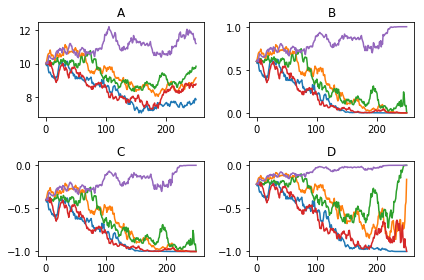

In [7]:
def save_to_csv(x, fig_numb, let):
    """ """
    cl = ['path_{0}'.format(i) for i in range(x.shape[1])]
    pd.DataFrame(x, columns=cl).to_csv(opst.csv_let_name(let, fig_numb), index=None)
    
# all charts in one figure
paths = opst.stock_paths(stock, show_plots=False)
deltas_call = opst.option_deltas(opt_call, stock, mark, show_plots=False)
deltas_put = opst.option_deltas(opt_put, stock, mark, show_plots=False)
deltas_put2 = opst.option_deltas(opt_put2, stock, mark, show_plots=False)
fig_numb = fig_numb + 1
a = subplot(2,2,1)
#setp(a.get_xticklabels(), visible=False)
for j in range(paths.shape[1]):
    plot(paths[:, j])
title('A')
b = subplot(2,2,2)
#setp(b.get_xticklabels(), visible=False)
for j in range(deltas_call.shape[1]):
    plot(deltas_call[:, j])
title('B')
c = subplot(2,2,3)
for j in range(deltas_call.shape[1]):
    plot(deltas_put[:, j])
title('C')
d = subplot(2,2,4)
for j in range(deltas_call.shape[1]):
    plot(deltas_put2[:, j])
title('D')
tight_layout()

# saving data to files
save_to_csv(paths, fig_numb, 'A')
save_to_csv(deltas_call, fig_numb, 'B')
save_to_csv(deltas_put, fig_numb, 'C')
save_to_csv(deltas_put2, fig_numb, 'D')

# saving figure to file
savefig(opst.fig_name(fig_numb))

## Option values along sample paths

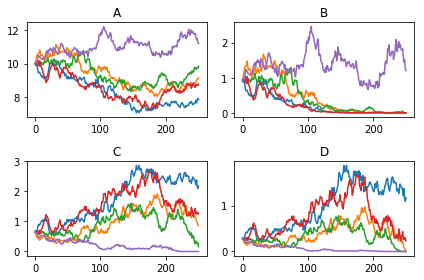

In [8]:
#values_call2 = opst.option_values(opt_call2, stock, mark, show_plots=False)
values_call = opst.option_values(opt_call, stock, mark, show_plots=False)
values_put = opst.option_values(opt_put, stock, mark, show_plots=False)
values_put2 = opst.option_values(opt_put2, stock, mark, show_plots=False)
fig_numb = fig_numb + 1

a = subplot(2,2,1)
for j in range(paths.shape[1]):
    plot(paths[:, j])
title('A')

b = subplot(2,2,2)
for j in range(values_call.shape[1]):
    plot(values_call[:, j])
title('B')

c = subplot(2,2,3)
for j in range(values_put.shape[1]):
    plot(values_put[:, j])
title('C')

d = subplot(2,2,4)
for j in range(values_put2.shape[1]):
    plot(values_put2[:, j])
title('D')
tight_layout()

# saving data to files
save_to_csv(paths, fig_numb, 'A')
save_to_csv(values_call, fig_numb, 'B')
save_to_csv(values_put, fig_numb, 'C')
save_to_csv(values_put2, fig_numb, 'D')

# saving figure ti file
savefig(opst.fig_name(fig_numb))

# Portfolios

## Comparison of Monte Carlo and Analytic VaR parameters

In [9]:
# generic portfolio processing
def portfolio_proc(opts, mark, stock, horizon=100, n_trials=25000, force_hedging=False):
    """ """
    # select hedging option position if there are one stock, one option, and force-hedging=True
    if force_hedging and (len(opts) == 1):
        option_new = opst.delta_hedged_position(opts[0], mark, stock)
        opts.clear()
        opts.append(option_new)
        print('Option hedging position: {0}'.format(option_new['cnt']))
    
    vals = opst.portfolio_distrib(opts, mark, stock, horizon=horizon, n_trials=n_trials)
    dsc = pd.Series(vals).describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])
    
    #  Monte Carlo and analytic parameters (99% VaR, 95% VaR, mean, standard deviation)
    a = dsc[['1%', '5%', 'mean', 'std']]
    sg = stock['sigma'] * np.sqrt(horizon / 250)
    prt_weight = np.abs(sum([(x['cnt'] * opst.greek_delta(x, mark, stock)) for x in opts]) + stock['cnt'])
    b = stock['S'] * prt_weight * np.array([norm.ppf(0.01), norm.ppf(0.05), 0, 1]) * sg
    ab = np.concatenate((a.values.reshape(1,4),b.reshape(1,4)), axis=0)
    mc_anal = pd.DataFrame(ab, columns=['99% VaR', '95% VaR', 'mean', 'std'], index=['Monte Carlo', 'Analytic'])
    return vals, mc_anal

## Single stock or one stock plus one option

              99% VaR   95% VaR      mean       std
Monte Carlo -2.266371 -1.600806 -0.001958  0.972088
Analytic    -2.279346 -1.611621  0.000000  0.979796
Monte Carlo -3.233322 -2.413664 -0.041317  1.540043
Analytic    -3.644005 -2.576508  0.000000  1.566406
Monte Carlo -0.809596 -0.703436  0.033133  0.569968
Analytic    -1.364659 -0.964888  0.000000  0.586610
Monte Carlo -1.283896 -1.061116  0.033580  0.752894
Analytic    -1.780995 -1.259260  0.000000  0.765576


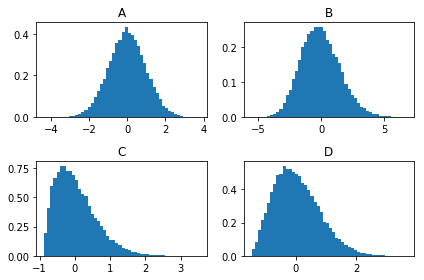

In [10]:
stock = opst.stock_def(S=S0, sigma=0.2, cnt=1)
hor = 60
fig_numb = fig_numb + 1

opts = []
vals_stock, mc_anal = portfolio_proc(opts, mark, stock, horizon=hor)

a = subplot(2,2,1)
hist(vals_stock, bins=50, normed=True)
title('A')
pd.DataFrame(vals_stock, columns=['Portfolio values']).to_csv(opst.csv_let_name('A', fig_numb), index=False)

opts = [opt_call]
vals_call, mc_anal_call = portfolio_proc(opts, mark, stock, horizon=hor)
mc_anal = pd.concat((mc_anal, mc_anal_call))

b = subplot(2,2,2)
hist(vals_call, bins=50, normed=True)
title('B')
pd.DataFrame(vals_call, columns=['Portfolio values']).to_csv(opst.csv_let_name('B', fig_numb), index=False)

opts = [opt_put]
vals_put, mc_anal_put = portfolio_proc(opts, mark, stock, horizon=hor)
mc_anal = pd.concat((mc_anal, mc_anal_put))

c = subplot(2,2,3)
hist(vals_put, bins=50, normed=True)
title('C')
pd.DataFrame(vals_put, columns=['Portfolio values']).to_csv(opst.csv_let_name('C', fig_numb), index=False)

opts = [opt_put2]
vals_put2, mc_anal_put2 = portfolio_proc(opts, mark, stock, horizon=hor)
mc_anal = pd.concat((mc_anal, mc_anal_put2))

d = subplot(2,2,4)
hist(vals_put2, bins=50, normed=True)
title('D')
pd.DataFrame(vals_put2, columns=['Portfolio values']).to_csv(opst.csv_let_name('D', fig_numb), index=False)
tight_layout()

mc_anal.to_csv(opst.csv_name(fig_numb))
print(mc_anal)
savefig(opst.fig_name(fig_numb))

## Single stock plus delta hedging options postion

Option hedging position: -17.74350788111566
Option hedging position: 38.58713679788157
Option hedging position: 165.15857480027842
               99% VaR    95% VaR      mean        std
Monte Carlo  -0.918847  -0.654114  0.002136   0.399860
Analytic     -0.930539  -0.657941  0.000000   0.400000
Monte Carlo  -9.999331  -6.730554  0.044337   3.831912
Analytic     -8.954718  -6.331470  0.000000   3.849260
Monte Carlo -10.936973  -8.384044  0.190538   5.939703
Analytic    -13.478649  -9.530133  0.000000   5.793910
Monte Carlo -24.736562 -19.579197  0.622138  14.596166
Analytic    -32.671117 -23.100245  0.000000  14.043952


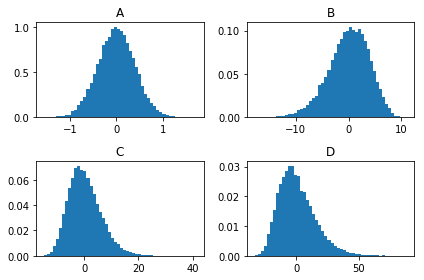

In [11]:
def make_sub_plot(x, let, plot_numb, fig_numb):
    """ """
    a = subplot(2,2,plot_numb)
    hist(x, bins=50, normed=True)
    title(let)
    pd.DataFrame(x, columns=['Portfolio values']).to_csv(opst.csv_let_name(let, fig_numb), index=False)

stock = opst.stock_def(S=S0, sigma=0.2, cnt=1)
hor = 10
fig_numb = fig_numb + 1

opts = []
vals_stock, mc_anal_stock = portfolio_proc(opts, mark, stock, horizon=hor, force_hedging=True)
make_sub_plot(vals_stock, 'A', 1, fig_numb)

opts = [opt_call]
vals_call, mc_anal_call = portfolio_proc(opts, mark, stock, horizon=hor, force_hedging=True)
make_sub_plot(vals_call, 'B', 2, fig_numb)

opts = [opt_put]
vals_put, mc_anal_put = portfolio_proc(opts, mark, stock, horizon=hor, force_hedging=True)
make_sub_plot(vals_put, 'C', 3, fig_numb)

opts = [opt_put2]
vals_put2, mc_anal_put2 = portfolio_proc(opts, mark, stock, horizon=hor, force_hedging=True)
make_sub_plot(vals_put2, 'D', 4, fig_numb)

tight_layout()
savefig(opst.fig_name(fig_numb))

mc_anal = pd.concat((mc_anal_stock, mc_anal_call, mc_anal_put, mc_anal_put2))
print(mc_anal)
mc_anal.to_csv(opst.csv_name(fig_numb))
